In [ ]:
"""
 def check_robots(self):
        for robot in model.schedule.agents:
            # Revisar que no colisionen en x
            if self.position[0] + 1 == robot.position[0] or self.position[0] - 1 == robot.position[0]:
                robot.speed[0] = 0
                if robot.carrying == True:
                    robot.current_box.speed = robot.speed
                
            # Revisar que no colisionen en y
            if self.position[1] + 1 == robot.position[1] or self.position[1] - 1 == robot.position[1]:
                robot.speed[1] = 0
                if robot.carrying == True:
                    robot.current_box.speed = robot.speed
"""

In [444]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [445]:
class Box(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        self.width = width
        self.height = height
        
        # Posicion
        self.position = np.array((x, y), dtype = int)
        
        # Estado
        self.still = True
        self.ordered = False
        
        # Velocidad
        self.speed = np.array((0,0), dtype = int)
        
    def step(self):
        if self.still == False and self.ordered == False:
            self.position = self.position + self.speed

In [446]:
class Robot(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        # Posicion
        self.position = np.array((x,y), dtype = int)
        
        # Posicion donde el robot va a ordenar las cajas
        self.order_pos = np.array((1,1), dtype = int)
        
        # Velocidad
        vel_x = np.random.randint(2)
        vel_y = np.random.randint(2)
        self.speed = np.array((vel_x, vel_y), dtype = int)
        
        self.width = width
        self.height = height
        
        # Movimientos realizados por el agente
        self.movimientos = 0
        
        # Posibles direcciones a las que podrá moverse
        self.directions = ["North", "South", "East", "West"]
        
        # Estado con caja o sin caja
        self.carrying = False
        
        # Caja que el robot está cargando
        self.current_box = None
        
    def step(self):
        self.check_edges()
        self.move()
        self.check_placing_pos()
        
        if self.carrying == True:
            self.get_to_perimeter()
            self.carry_box_to()
            self.move()
            self.current_box.speed = self.speed
            self.place_box()      
        else:
            self.move_box()
      
        self.position = self.position + self.speed
        self.movimientos += 1
        
    #Revisar que el robot no salga de los límites establecidos
    def check_edges(self):
        self.directions = ["North", "South", "East", "West"]
        
        # Eje x
        if self.position[0] >= self.width - 1:
            self.directions.remove("East")
        elif self.position[0] <= 1:
            self.directions.remove("West")
        
        # Eje y
        if self.position[1] >= self.height - 1:
            self.directions.remove("North")
        elif self.position[1] <= 1:
            self.directions.remove("South")
    
    # Función para seleccionar al azar la posición a la que se moverá el robot
    def move(self):
        des = np.random.choice(self.directions)
        if des == 'North':
            self.North()
        elif des == 'South':
            self.South()
        elif des == 'East':
            self.East()
        elif des == 'West':
            self.West()
        
    # Posibles direcciones a las que el robot se puede mover
    def North(self):
        self.speed = np.array((0, 1), dtype = int)
        
    def South(self):
        self.speed = np.array((0, -1), dtype = int)
        
    def East(self):
        self.speed = np.array((1, 0), dtype = int)
        
    def West(self):
        self.speed = np.array((-1, 0), dtype = int)
        
    #def move_to_box(self):
        # Revisar que el arreglo de las posiciones de las cajas contenga elementos
            
    # Función para que el robot recoja la caja de la posición en la que se encuentra si es que hay una
    def move_box(self):
        for box in model.props.agents:
            if self.position[0] == box.position[0] and self.position[1] == box.position[1] and box.ordered == False:
                box.still = False
                box.speed = self.speed
                self.carrying = True
                self.current_box = box
    
    # Función para que el robot coloque la caja en la posición correspondiente
    def place_box(self):
        if self.current_box.position[0] == self.order_pos[0] and self.current_box.position[1] == self.order_pos[1] and self.current_box.still == False:
            model.ordered_boxes.append(self.current_box)
            self.current_box.still = True
            self.current_box.ordered = True
            self.carrying = False
            self.current_box = None
            
    def check_placing_pos(self):
        for box in model.ordered_boxes:
            if box.position[0] == self.order_pos[0] and box.position[1] == self.order_pos[1]:
                self.order_pos[0] += 1
            
        if self.order_pos[0] > 5:
            self.order_pos[1] += 1
            self.order_pos[0] = 1
    
    # Función para que el robot llegue a la ruta para colocar la caja
    def get_to_perimeter(self):
        if self.position[1] < self.height - 1:
            self.directions = ["North"]
            
    
    # Función para que una vez estando en el perímetro el robot se dirija hacia la posición donde ordenará la caja
    def carry_box_to(self):
        # Arriba
        if self.position[1] == self.height - 1 and 1 <= self.position[0] < self.width - 1:
            self.directions = ["East"]
        
        # Derecha
        elif self.position[0] == self.width - 1 and self.order_pos[1] < self.position[1] <= self.height - 1:
            self.directions = ["South"]
           
        # Abajo
        elif self.position[1] == self.order_pos[1] and self.order_pos[0] <= self.position[0] <= self.width - 1:
            self.directions = ["West"]
                

In [447]:
def get_robots(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

def get_boxes(model):
    result = []
    for box in model.props.agents:
        result.append(box.position)
    result = np.asarray(result)
    return result

class Ordenar(Model):
    def __init__(self, N, width, height, k):
        self.num_robots = N
        self.schedule = RandomActivation(self)
        self.props = RandomActivation(self)
        
        # Arreglo de cajas por acomodar
        self.box_positions = []
        
        # Arreglo de cajas acomodadas
        self.ordered_boxes = []
        
        
        temp = []
        i = 0
        while i in range(k):
            x = np.random.randint(1, width - 1)
            y = np.random.randint(2, height - 1)
            pos = [x,y]
            
            if pos in temp:
                continue
            
            box = Box(i, self, x, y, width, height)
            self.props.add(box)
            self.box_positions.append(pos)
            temp.append(pos)
            i += 1
        
        i = 0
        while i in range(self.num_robots):
            x = np.random.randint(1, width - 1)
            y = np.random.randint(1, height - 1)
            pos = [x, y]
            
            if pos in temp:
                continue
            
            r = Robot(i, self, x, y, width, height)
            self.schedule.add(r)
            temp.append(pos)
            i += 1
            
        self.datacollector = DataCollector(model_reporters = {"Robots" : get_robots, "Boxes" : get_boxes})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.props.step()
        
    def get_movements(self):
        total = 0
        for agent in model.schedule.agents:
            total += agent.movimientos
        return total


In [452]:
WIDTH = 10
HEIGHT = 10
K = 20
N = 5
MAX_ITERATIONS = 500

start_time = time.time()

model = Ordenar(N, WIDTH, HEIGHT, K)
for i in range(MAX_ITERATIONS):
    model.step()

movimientos = model.get_movements()    

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print("Total de movimientos de todos los agentes = " + str(movimientos))

Tiempo de ejecución: 0:00:00.138228
Total de movimientos de todos los agentes = 2500


In [453]:
all_positions = model.datacollector.get_model_vars_dataframe()

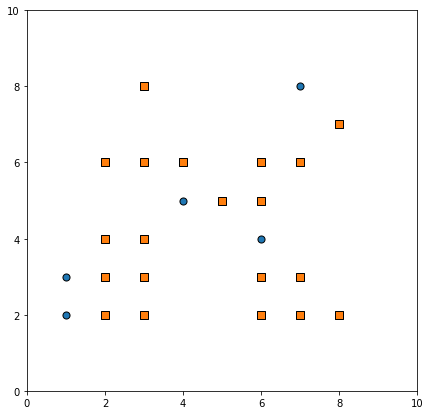

In [454]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=50, cmap="jet", edgecolor="k",  marker="o")

boxes = ax.scatter(all_positions.iloc[0][1][:,0], all_positions.iloc[0][1][:,1], 
                  s=80, cmap="jet", edgecolor="k", marker="s")


ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    boxes.set_offsets(all_positions.iloc[frame_number][1])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

In [455]:
anim